In [1]:
%matplotlib inline 
import climlab

import numpy as np
import xarray as xr

from matplotlib import pyplot as plt

import scipy.integrate as sp  #Gives access to the ODE integration package
from attrdict import AttrDict

In [2]:
class Dummy:
    pass

params = Dummy()

params.eps   = 0.622 # molar mass ratio of vapour to total moist air
params.L     = 2260000 # Latent heat of vap, water, J/kg

params.R_a   = 287.058 # gas constant for dry air, J/kg/K
params.R_c   = 461.5  # gas constant for water vapour, J/kg/K
params.cp_a  = 1004 # specific heat capacity of air, J/kg/K

params.Tstrat = 200 # isothermal stratosphere, K

params.RH = 0.8

In [3]:
# Define functions

def q(T, P): # specific humidity at saturation (using Clausius-Clapeyron)
    return climlab.utils.thermo.qsat(T, P)

def moist_adiabat(T, P): # Pressure coords gives dT/dP (if using the T/P prefactor)
    return np.divide(T, P) * np.divide(params.R_a, params.cp_a) * np.divide(1 + np.divide(params.L*q(T, P), params.R_a * T), 
                                                                            1 + np.divide(params.L**2 * q(T, P), params.cp_a * params.R_c * T**2))

# Or, equivalently...
def pseudoadiabat(T,p):
    return climlab.utils.thermo.pseudoadiabat(T, p)

def dry_adiabat(T,p):
    return np.divide(params.R_a, params.cp_a)

def generate_idealized_temp_profile(SST, Tstrat, plevs):
    solution = sp.odeint(pseudoadiabat, SST, np.flip(plevs))
    temp = solution.reshape(-1)
    temp[np.where(temp<Tstrat)] = Tstrat
    return np.flip(temp) # need to re-invert the pressure axis

def generate_idealized_temp_profile_dry(SST, Tstrat, plevs):
    solution = sp.odeint(dry_adiabat, SST, np.flip(plevs))
    temp = solution.reshape(-1)
    temp[np.where(temp<Tstrat)] = Tstrat
    return np.flip(temp) # need to re-invert the pressure axis

In [4]:
pressure = np.flip(np.linspace(1e3, 10))

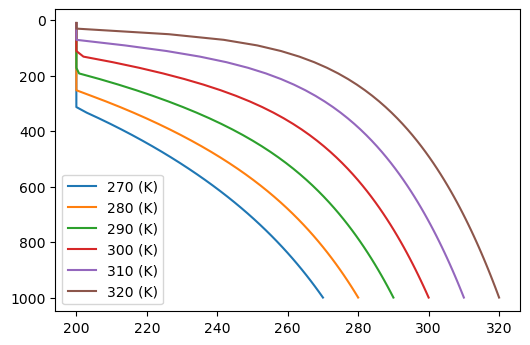

In [5]:
fig, ax = plt.subplots(dpi=100)


for temp in [270, 280, 290, 300, 310, 320]:
    adiabat = generate_idealized_temp_profile(SST=temp, Tstrat=200, plevs=pressure)
    ax.plot(adiabat, pressure, label=f"{temp} (K)")

ax.invert_yaxis()
ax.legend()

In [6]:
generate_idealized_temp_profile(SST=320, Tstrat=200, plevs=pressure)

array([200.        , 200.        , 226.24820127, 241.82849202,
       251.34964967, 258.07902137, 263.28782514, 267.55026285,
       271.16790789, 274.31768044, 277.11205673, 279.62698841,
       281.91619632, 284.01909732, 285.9654897 , 287.77846476,
       289.47627973, 291.0736355 , 292.58254641, 294.0129584 ,
       295.37320257, 296.67033518, 297.91037465, 299.09850831,
       300.23923151, 301.3364746 , 302.39368939, 303.41391943,
       304.39987391, 305.35396593, 306.27835966, 307.17500115,
       308.04564757, 308.89189067, 309.71517937, 310.51683453,
       311.29806191, 312.05996999, 312.80357354, 313.52981145,
       314.23954975, 314.93358839, 315.61267097, 316.27748899,
       316.92868546, 317.56686022, 318.19257184, 318.80634365,
       319.40866082, 320.        ])

In [7]:
generate_idealized_temp_profile(SST=321, Tstrat=200, plevs=pressure)

array([200.        , 203.45740383, 230.96424045, 245.18674432,
       253.98028308, 260.30610312, 265.26402617, 269.35610743,
       272.85046179, 275.90671553, 278.62758862, 281.08312255,
       283.32325601, 285.38487312, 287.2960127 , 289.07850128,
       290.74966795, 292.32351577, 293.81151932, 295.22320575,
       296.56657426, 297.84841401, 299.074525  , 300.24991568,
       301.37893439, 302.46538743, 303.51262013, 304.52358881,
       305.50092517, 306.44697781, 307.3638531 , 308.2534484 ,
       309.11747695, 309.95749281, 310.77491133, 311.57102339,
       312.3470084 , 313.10395099, 313.84284489, 314.56460984,
       315.27009489, 315.96008428, 316.63530773, 317.29644389,
       317.94412416, 318.57893768, 319.20143335, 319.81212555,
       320.4114915 , 321.        ])

# What about dT/dTs at fixed P?

/home/users/andreww/miniconda3/envs/ecsbump/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/users/andreww/miniconda3/envs/ecsbump/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 1.0, 'Amplified warming along $\\Gamma_{moist}$')

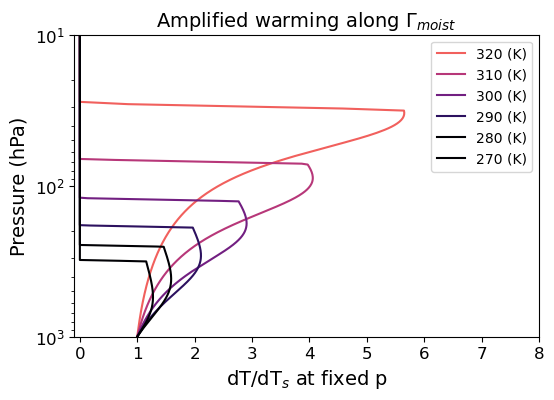

In [8]:
import matplotlib
pressure = np.flip(np.linspace(1e3, 10, 1000))

fig, ax = plt.subplots(dpi=100)

colormap = plt.cm.magma 
normalize = matplotlib.colors.Normalize(vmin=280, vmax=340)

for temp in [320, 310, 300, 290, 280, 270]:
    dTdTs = generate_idealized_temp_profile(SST=temp+1, Tstrat=200, plevs=pressure) - generate_idealized_temp_profile(SST=temp, Tstrat=200, plevs=pressure)
    ax.plot(dTdTs, pressure, color=colormap(normalize(temp)), label=f"{temp} (K)")

ax.invert_yaxis()

ax.set_xlim(-0.1, 8)
ax.set_ylim(1e3, 10)

_ = ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=12)
_ = ax.set_yticklabels(ax.get_yticks(), fontsize=12)

ax.set_yscale('log')
ax.legend()

ax.set_ylabel("Pressure (hPa)", fontsize=14)
ax.set_xlabel(r"$\mathrm{dT}/\mathrm{dT}_{s}$ at fixed p", fontsize=14)

ax.set_title("Amplified warming along $\Gamma_{moist}$", fontsize=14)

# Thus, decrease in moist lapse rate with warming!

# So, how does lapse rate affect optical depth calculation?


$$ \tau_{\nu} \approx \frac{\kappa_{\nu}\epsilon}{g}\int\mathrm{e_{sat}}(T) \, \frac{dT}{\Gamma}$$

In [9]:
plevs = np.flip(np.linspace(1e3, 10))
temps = generate_idealized_temp_profile(SST=250, Tstrat=180, plevs=plevs)

In [10]:
dtau = q(temps, plevs)*(1/pseudoadiabat(temps, np.flip(plevs)))

In [11]:
from scipy.integrate import trapz,simps,cumtrapz

tau = cumtrapz(dtau,x=temps)

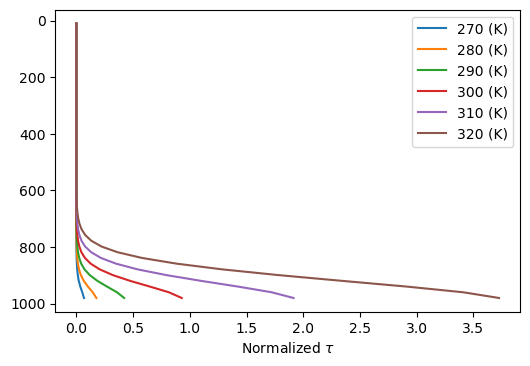

In [16]:
fig, ax = plt.subplots(dpi=100)

for temp in [270, 280, 290, 300, 310, 320]:
    temps = generate_idealized_temp_profile_dry(SST=temp, Tstrat=200, plevs=plevs)
    dtau = q(temps, plevs)*(1/pseudoadiabat(temps, np.flip(plevs)))
    tau = cumtrapz(dtau,x=temps)
    #tau = tau/np.max(tau)
    ax.plot(tau, plevs[:-1], label=f"{temp} (K)")

ax.set_xlabel(r"Normalized $\tau$")
ax.invert_yaxis()
ax.legend()

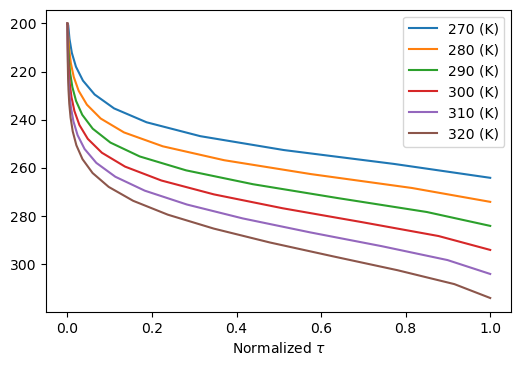

In [19]:
fig, ax = plt.subplots(dpi=100)

for temp in [270, 280, 290, 300, 310, 320]:
    temps = generate_idealized_temp_profile_dry(SST=temp, Tstrat=200, plevs=plevs)
    dtau = q(temps, plevs)*(1/pseudoadiabat(temps, np.flip(plevs)))
    tau = cumtrapz(dtau,x=temps)
    tau = tau/np.max(tau)
    ax.plot(tau, temps[:-1], label=f"{temp} (K)")

ax.set_xlabel(r"Normalized $\tau$")
ax.invert_yaxis()
ax.legend()

>>> For the second effect, which I would guess primarily affects the H2O continuum regions, a decreasing lapse rate means when you integrate water vapor path over Clausius-Clapeyron, there is more mass at a given temperature, which causes the emission-level optical depths to occur at a slightly *lower* atmospheric temperature for +1 K warming, yielding a negative feedback (less OLR with warming). I have not confirmed either of these arguments quantitatively, but I think it should be possible to write down a few equations to compare the predicted sign and magnitude of these effects with what the LBL model shows. That would actually be an important thing for our paper to do, since it would show we understand why RRTM underestimates the feedback — but I don't think either of those arguments explains the swing back up in RRTM's brown band. For comparison with RRTM, and in case you want to look into deviations from Simpsonian behavior, I'm attaching the H2O-only spectral feedback calculated by the RFM.


# PyRADS

In [ ]:
def compute_tau_H2ON2_CO2nondilute(p,T,q,ppv_CO2,grid,params,RH=1.):

    kappa = np.zeros( (grid.Np,grid.Nn) )
    kappa_h2o = np.zeros( (grid.Np,grid.Nn) )
    kappa_co2 = np.zeros( (grid.Np,grid.Nn) )
    for pres,temp,q_H2O in zip(p,T,q):
        p_CO2 = pres * ppv_CO2
        p_H2O = RH * params.esat(temp)  # ...

        q_CO2 = convert_molar_to_mass_ratio(ppv_CO2,params.R_CO2,R_mean)

        R_mean = q_H2O*params.Rv + q_CO2*params.R_CO2 + (1.-q_H2O - q_CO2)*params.R


        kappaH2O = getKappa_HITRAN(grid.n,grid.n0,grid.n1,grid.dn, \
                                   "H2O",press=pres,press_self=p_H2O, \
                                   temp=temp,broadening="mixed", lineWid=25., \
                                   cutoff_option="fixed",remove_plinth=True)

        kappaCO2 = getKappa_HITRAN(grid.n,grid.n0,grid.n1,grid.dn, \
                                   "CO2",press=pres,press_self=p_CO2, \
                                   temp=temp,broadening="mixed", lineWid=25., \
                                   cutoff_option="fixed",remove_plinth=False)
        # add continuum:
        #    here I'm only using kappa from mtckd crosssection file,
        #    which doesn't include N2-N2 and similar continua.
        kappaH2O_cont = get_H2OContinuum(grid.n,temp,pres,p_H2O, \
                            exe_file=Absorption_Continuum_MTCKD.mtckd_exe_H2O_N2)

        kappa[ p==pres,: ] = kappaH2O*q_H2O + kappaH2O_cont*q_H2O + kappaCO2*q_CO2  # save
        kappa_h2o[ p==pres,: ] = kappaH2O*q_H2O + kappaH2O_cont*q_H2O  # save
        kappa_co2[ p==pres,: ] = kappaCO2*q_CO2  # save
    print( "done! \n")

    # Integrate to get optical thickness:
    p2d = np.tile( p,(grid.Nn,1) ).T
    tau     = 1./(params.g*params.cosThetaBar) * cumtrapz( kappa,x=p2d,initial=0.,axis=0 )
    tau_h2o = 1./(params.g*params.cosThetaBar) * cumtrapz( kappa_h2o,x=p2d,initial=0.,axis=0 )
    tau_co2 = 1./(params.g*params.cosThetaBar) * cumtrapz( kappa_co2,x=p2d,initial=0.,axis=0 )
    return tau, tau_h2o, tau_co2



In [14]:
def calc_tau_pyrads(SST, Tstrat, CO2ppmv, dnu=0.1, nu_min=0.1, nu_max=3500, npres=30, rh=0.8):
    ## PyRADS
    #import os
    #os.chdir('/Users/andrewwilliams/Desktop/PhD/Projects/PyRADS/')
    import pyrads
    import numpy as np
    from scipy.integrate import trapz,simps,cumtrapz

    class Dummy:
        pass

    params_pyrads = Dummy()

    params_pyrads.Rv = pyrads.phys.H2O.R # moist component
    params_pyrads.cpv = pyrads.phys.H2O.cp
    params_pyrads.Lvap = pyrads.phys.H2O.L_vaporization_TriplePoint
    params_pyrads.satvap_T0 = pyrads.phys.H2O.TriplePointT
    params_pyrads.satvap_e0 = pyrads.phys.H2O.TriplePointP
    params_pyrads.esat = lambda T: pyrads.Thermodynamics.get_satvps(T,
                                                              params_pyrads.satvap_T0,
                                                              params_pyrads.satvap_e0,
                                                              params_pyrads.Rv,
                                                              params_pyrads.Lvap)

    params_pyrads.R = pyrads.phys.air.R  # dry component
    params_pyrads.R_CO2 = pyrads.phys.CO2.R
    params_pyrads.cp = pyrads.phys.air.cp
    params_pyrads.ps_dry = 1e5           # surface pressure of dry component

    params_pyrads.g = 9.81             # surface gravity
    params_pyrads.cosThetaBar = 3./5.  # average zenith angle used in 2stream eqns
    params_pyrads.RH = rh             # relative humidity

    # setup resolution
    N_press = npres
    dwavenr = dnu

    wavenr_min = nu_min  # [cm^-1]
    wavenr_max = nu_max  #

    # setup grid:
    g = pyrads.SetupGrids.make_grid(SST,Tstrat,N_press,
                                    wavenr_min,wavenr_max,dwavenr,
                                    params_pyrads,RH=params_pyrads.RH )

    
    """
    return g
    #  Couple water vapor to radiation
    ## climlab setup
    # create surface and atmosperic domains
    state = climlab.column_state(num_lev=N_press, num_lat=1, water_depth=1.)
    plevs = state['Tatm'].domain.axes['lev'].points
    g.p = plevs*100 # Convert hPa->Pa for PyRADS computation
    
    state['Ts'][:] = SST
    state['Tatm'][:] = generate_idealized_temp_profile(SST, Tstrat, g.p/100) # This function requires pressure in hPa !
    g.T = generate_idealized_temp_profile(SST, Tstrat, g.p/100)
    
    #  fixed relative humidity
    h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                              relative_humidity=params_pyrads.RH)
    
    g.q = h2o.q
    """
    # Set stratospheric spec hum to tropopause value (approximate)
    if np.any(g.T==Tstrat):
        mask = g.T<=Tstrat
        q_trop = g.q[~mask][0]
        g.q[mask] = q_trop
    
    # compute optical thickness:
    g.tau, g.tau_h2o, g.tau_co2 = pyrads.OpticalThickness.compute_tau_H2ON2_CO2dilute(g.p, g.T, g.q, 
                                                                                      CO2ppmv/1e6, g, 
                                                                                      params_pyrads, RH=params_pyrads.RH)
    
    return [g.tau, g.tau_h2o, g.tau_co2, g.n, g.p]

In [21]:
%%time
outp100_base = calc_tau_pyrads(SST=300, Tstrat=200, CO2ppmv=4594, npres=100)

compute kappa at p,T =  10.286507766663084 200.0
compute kappa at p,T =  11.289429575147462 200.0
compute kappa at p,T =  12.390135021845145 200.0
compute kappa at p,T =  13.598157890767322 200.0
compute kappa at p,T =  14.923961498096801 200.0
compute kappa at p,T =  16.379029320427136 200.0
compute kappa at p,T =  17.97596445914334 200.0
compute kappa at p,T =  19.728598802456883 200.0
compute kappa at p,T =  21.652112830604207 200.0
compute kappa at p,T =  23.76316710190449 200.0
compute kappa at p,T =  26.08004655854537 200.0
compute kappa at p,T =  28.622818902004987 200.0
compute kappa at p,T =  31.413508409881775 200.0
compute kappa at p,T =  34.47628669965097 200.0
compute kappa at p,T =  37.83768209165163 200.0
compute kappa at p,T =  41.52680938470636 200.0
compute kappa at p,T =  45.57562203458072 200.0
compute kappa at p,T =  50.01918891953044 200.0
compute kappa at p,T =  54.89599809014864 200.0
compute kappa at p,T =  60.24829013444728 200.0
compute kappa at p,T =  66.122

In [22]:
tau100_base = xr.DataArray(outp100_base[0], dims=['pres', 'nu'], coords={'pres':outp100_base[4], 'nu':outp100_base[3]})

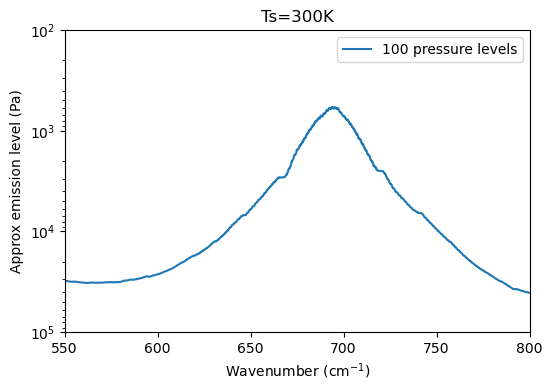

In [24]:
fig, ax = plt.subplots(dpi=100)

ax.plot(tau100_base.nu.sel(nu=slice(550, 800)), 
        np.abs(tau100_base -0.5).idxmin('pres').rolling(nu=500).mean().sel(nu=slice(550, 800)), label='100 pressure levels')


ax.set_xlabel(r"Wavenumber (cm$^{-1}$)")
ax.set_ylabel(r"Approx emission level (Pa)")
ax.invert_yaxis()
ax.set_title("Ts=300K")
ax.set_yscale('log')
ax.set_ylim(1e5, 1e2)
ax.set_xlim(550, 800)
ax.legend()

In [44]:
%%time
outp30 = calc_tau_pyrads(SST=300, Tstrat=200, CO2ppmv=4594, npres=30) # Approx CO2 from rrtmg

compute kappa at p,T =  1666.6666666666667 200.0
compute kappa at p,T =  5000.0 200.0
compute kappa at p,T =  8333.333333333334 200.0
compute kappa at p,T =  11666.666666666668 200.0
compute kappa at p,T =  15000.0 211.455220714533
compute kappa at p,T =  18333.333333333336 223.52624109834602
compute kappa at p,T =  21666.666666666664 233.5893585756761
compute kappa at p,T =  25000.0 241.93649152128594
compute kappa at p,T =  28333.333333333336 248.8597084826924
compute kappa at p,T =  31666.666666666668 254.6515598049824
compute kappa at p,T =  35000.00000000001 259.5665136443421
compute kappa at p,T =  38333.333333333336 263.8045727430358
compute kappa at p,T =  41666.66666666667 267.5154543435426
compute kappa at p,T =  45000.00000000001 270.80961740377325
compute kappa at p,T =  48333.333333333336 273.7688252986699
compute kappa at p,T =  51666.66666666667 276.4543361020357
compute kappa at p,T =  55000.0 278.91273950943935
compute kappa at p,T =  58333.333333333336 281.18006062769

In [23]:
%%time
outp = calc_tau_pyrads(SST=300, Tstrat=200, CO2ppmv=4594, npres=100) # Approx CO2 from rrtmg

compute kappa at p,T =  500.0 200.0
compute kappa at p,T =  1500.0 200.0
compute kappa at p,T =  2500.0 200.0
compute kappa at p,T =  3500.0 200.0
compute kappa at p,T =  4500.0 200.0
compute kappa at p,T =  5500.0 200.0
compute kappa at p,T =  6500.0 200.0
compute kappa at p,T =  7500.0 200.0
compute kappa at p,T =  8500.0 200.0
compute kappa at p,T =  9500.0 200.0
compute kappa at p,T =  10500.0 200.0
compute kappa at p,T =  11500.0 200.0
compute kappa at p,T =  12500.0 200.0
compute kappa at p,T =  13500.0 204.12657361231578
compute kappa at p,T =  14500.0 208.29620163009787
compute kappa at p,T =  15500.0 212.243094963304
compute kappa at p,T =  16500.0 215.9840158303102
compute kappa at p,T =  17500.0 219.53202839276855
compute kappa at p,T =  18500.0 222.89754917028293
compute kappa at p,T =  19500.0 226.08921838573983
compute kappa at p,T =  20500.0 229.1146010791444
compute kappa at p,T =  21500.0 231.98074729789667
compute kappa at p,T =  22500.0 234.6945735726941
compute kapp

In [30]:
%%time
outp300 = calc_tau_pyrads(SST=300, Tstrat=200, CO2ppmv=4594, npres=300) # Approx CO2 from rrtmg

compute kappa at p,T =  166.66666666666669 200.0
compute kappa at p,T =  500.0 200.0
compute kappa at p,T =  833.3333333333334 200.0
compute kappa at p,T =  1166.6666666666665 200.0
compute kappa at p,T =  1500.0 200.0
compute kappa at p,T =  1833.3333333333335 200.0
compute kappa at p,T =  2166.666666666667 200.0
compute kappa at p,T =  2500.0000000000005 200.0
compute kappa at p,T =  2833.3333333333335 200.0
compute kappa at p,T =  3166.666666666667 200.0
compute kappa at p,T =  3500.0 200.0
compute kappa at p,T =  3833.3333333333335 200.0
compute kappa at p,T =  4166.666666666666 200.0
compute kappa at p,T =  4500.0 200.0
compute kappa at p,T =  4833.333333333334 200.0
compute kappa at p,T =  5166.666666666666 200.0
compute kappa at p,T =  5500.0 200.0
compute kappa at p,T =  5833.333333333334 200.0
compute kappa at p,T =  6166.666666666666 200.0
compute kappa at p,T =  6500.0 200.0
compute kappa at p,T =  6833.333333333334 200.0
compute kappa at p,T =  7166.666666666667 200.0
compu

In [39]:
%%time
outp1000 = calc_tau_pyrads(SST=300, Tstrat=200, CO2ppmv=4594, npres=1000) # Approx CO2 from rrtmg

compute kappa at p,T =  50.0 200.0
compute kappa at p,T =  150.0 200.0
compute kappa at p,T =  250.0 200.0
compute kappa at p,T =  350.0 200.0
compute kappa at p,T =  450.0 200.0
compute kappa at p,T =  550.0 200.0
compute kappa at p,T =  650.0 200.0
compute kappa at p,T =  750.0 200.0
compute kappa at p,T =  850.0 200.0
compute kappa at p,T =  950.0 200.0
compute kappa at p,T =  1050.0 200.0
compute kappa at p,T =  1150.0 200.0
compute kappa at p,T =  1250.0 200.0
compute kappa at p,T =  1350.0 200.0
compute kappa at p,T =  1450.0 200.0
compute kappa at p,T =  1550.0 200.0
compute kappa at p,T =  1650.0 200.0
compute kappa at p,T =  1750.0 200.0
compute kappa at p,T =  1850.0 200.0
compute kappa at p,T =  1950.0 200.0
compute kappa at p,T =  2050.0 200.0
compute kappa at p,T =  2150.0 200.0
compute kappa at p,T =  2250.0 200.0
compute kappa at p,T =  2350.0 200.0
compute kappa at p,T =  2450.0 200.0
compute kappa at p,T =  2550.0 200.0
compute kappa at p,T =  2650.0 200.0
compute kapp

In [45]:
state = climlab.column_state(num_lev=30, num_lat=1, water_depth=1.)
plevs30 = state['Tatm'].domain.axes['lev'].points

state = climlab.column_state(num_lev=100, num_lat=1, water_depth=1.)
plevs100 = state['Tatm'].domain.axes['lev'].points

state = climlab.column_state(num_lev=300, num_lat=1, water_depth=1.)
plevs300 = state['Tatm'].domain.axes['lev'].points

state = climlab.column_state(num_lev=1000, num_lat=1, water_depth=1.)
plevs1000 = state['Tatm'].domain.axes['lev'].points

In [24]:
n = outp[3]
n

array([1.0000e-01, 2.0000e-01, 3.0000e-01, ..., 3.4997e+03, 3.4998e+03,
       3.4999e+03])

In [46]:
tau30 = xr.DataArray(outp30[0], dims=['pres', 'nu'], coords={'pres':plevs30, 'nu':n})
tau100 = xr.DataArray(outp[0], dims=['pres', 'nu'], coords={'pres':plevs100, 'nu':n})
tau300 = xr.DataArray(outp300[0], dims=['pres', 'nu'], coords={'pres':plevs300, 'nu':n})
tau1000 = xr.DataArray(outp1000[0], dims=['pres', 'nu'], coords={'pres':plevs1000, 'nu':n})

In [28]:
np.abs(tau -1).idxmin('pres')

<xarray.DataArray 'pres' (nu: 34999)>
array([985., 955., 915., ..., 165., 305., 625.])
Coordinates:
  * nu       (nu) float64 0.1 0.2 0.3 0.4 ... 3.5e+03 3.5e+03 3.5e+03 3.5e+03

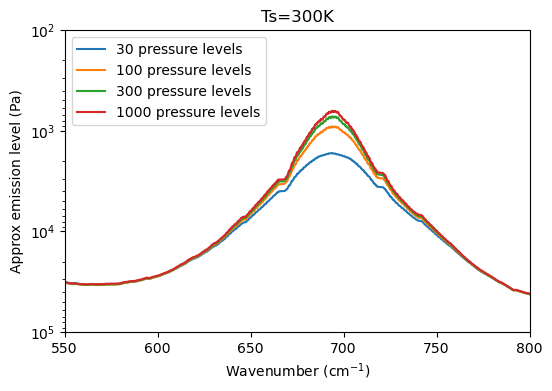

In [51]:
fig, ax = plt.subplots(dpi=100)

ax.plot(tau30.nu.sel(nu=slice(550, 800)), 
        np.abs(tau30 -0.5).idxmin('pres').rolling(nu=500).mean().sel(nu=slice(550, 800))*100, label='30 pressure levels')

ax.plot(tau100.nu.sel(nu=slice(550, 800)), 
        np.abs(tau100 -0.5).idxmin('pres').rolling(nu=500).mean().sel(nu=slice(550, 800))*100, label='100 pressure levels')

ax.plot(tau300.nu.sel(nu=slice(550, 800)), 
        np.abs(tau300 -0.5).idxmin('pres').rolling(nu=500).mean().sel(nu=slice(550, 800))*100, label='300 pressure levels')

ax.plot(tau1000.nu.sel(nu=slice(550, 800)), 
        np.abs(tau1000 -0.5).idxmin('pres').rolling(nu=500).mean().sel(nu=slice(550, 800))*100, label='1000 pressure levels')


ax.set_xlabel(r"Wavenumber (cm$^{-1}$)")
ax.set_ylabel(r"Approx emission level (Pa)")
ax.invert_yaxis()
ax.set_title("Ts=300K")
ax.set_yscale('log')
ax.set_ylim(1e5, 1e2)
ax.set_xlim(550, 800)
ax.legend()
plt.savefig("./emission_levels_vs_nu_different_nplevs.png", dpi=200, facecolor='white', bbox_inches='tight')